<a href="https://colab.research.google.com/github/michelleaeh/CE888_Assignment2/blob/master/Assignment2_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Michelle Alejandra Espinosa Hernandez**

**Registration Number: 1900964**

**CE888: Data Science and Decision Making**

**Assignment 2**

**Project 3: Decision Trees for Expert Iteration (Reinforcement learning)**





This is a very simple implementation of the UCT Monte Carlo Tree Search algorithm in Python 2.7.
The function UCT(rootstate, itermax, verbose = False) is towards the bottom of the code.
It aims to have the clearest and simplest possible code, and for the sake of clarity, the code is orders of magnitude less efficient than it could be made, particularly by using a 
state.GetRandomMove() or state.DoRandomRollout() function.
 
Example GameState classes for Nim, OXO and Othello are included to give some idea of how you can write your own GameState use UCT in your 2-player game. Change the game to be played in the UCTPlayGame() function at the bottom of the code.
 
Written by Peter Cowling, Ed Powley, Daniel Whitehouse (University of York, UK) September 2012.
 
Licence is granted to freely use and distribute for any sensible/legal purpose so long as this comment remains in any distributed code.
 
For more information about Monte Carlo Tree Search check out our web site at www.mcts.ai

**TASK 1**

Using the code provided here, generate (and collect) sample data for at least one kind of game (e.g., OXO, Othello). Sample data that includes combinations of state values (keep your encoding as close to the game mechanics as possible) and the action that the agent took. For example, for OXOState/Game, the state is the board and who is playing; the action is the action the MCTS/UCT took.


In [0]:
import numpy as np
import pandas as pd
import pydotplus
import random

from IPython.display import Image  
from math import *
from random import randint
from sklearn.externals.six import StringIO
from scipy.ndimage.interpolation import shift
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

class GameState:
    """ A state of the game, i.e. the game board. These are the only functions which are
        absolutely necessary to implement UCT in any 2-player complete information deterministic 
        zero-sum game, although they can be enhanced and made quicker, for example by using a 
        GetRandomMove() function to generate a random move during rollout.
        By convention the players are numbered 1 and 2.
    """
    def __init__(self):
            self.playerJustMoved = 2 # At the root pretend the player just moved is player 2 - player 1 has the first move
        
    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = GameState()
        st.playerJustMoved = self.playerJustMoved
        return st

    def DoMove(self, move):
        """ Update a state by carrying out the given move.
            Must update playerJustMoved.
        """
        self.playerJustMoved = 3 - self.playerJustMoved

    def GetMoves(self):
        """ Get all possible moves from this state.
        """
    
    def GetResult(self, playerjm):
        """ Get the game result from the viewpoint of playerjm. 
        """

    def __repr__(self):
        """ Don't need this - but good style.
        """
        pass

class OXOState:
    """ A state of the game, i.e. the game board.
        Squares in the board are in this arrangement
        012
        345
        678
        where 0 = empty, 1 = player 1 (X), 2 = player 2 (O)
    """
    def __init__(self):
        self.playerJustMoved = 2 # At the root pretend the player just moved is p2 - p1 has the first move
        self.board = [0,0,0,0,0,0,0,0,0] # 0 = empty, 1 = player 1, 2 = player 2
        
    def Clone(self):
        """ Create a deep clone of this game state.
        """
        st = OXOState()
        st.playerJustMoved = self.playerJustMoved
        st.board = self.board[:]
        return st

    def DoMove(self, move):
        """ Update a state by carrying out the given move.
            Must update playerToMove.
        """
        assert move >= 0 and move <= 8 and move == int(move) and self.board[move] == 0
        self.playerJustMoved = 3 - self.playerJustMoved
        self.board[move] = self.playerJustMoved
        
    def GetMoves(self):
        """ Get all possible moves from this state.
        """
        return [i for i in range(9) if self.board[i] == 0]
    
    def GetResult(self, playerjm):
        """ Get the game result from the viewpoint of playerjm. 
        """
        for (x,y,z) in [(0,1,2),(3,4,5),(6,7,8),(0,3,6),(1,4,7),(2,5,8),(0,4,8),(2,4,6)]:
            if self.board[x] == self.board[y] == self.board[z]:
                if self.board[x] == playerjm:
                    return 1.0
                else:
                    return 0.0
        if self.GetMoves() == []: return 0.5 # draw
        return False # Should not be possible to get here

    def __repr__(self):
        s= ""
        for i in range(9): 
            s += ".XO"[self.board[i]]
            if i % 3 == 2: s += "\n"
        return s

class Node:
    """ A node in the game tree. Note wins is always from the viewpoint of playerJustMoved.
        Crashes if state not specified.
    """
    def __init__(self, move = None, parent = None, state = None):
        self.move = move # the move that got us to this node - "None" for the root node
        self.parentNode = parent # "None" for the root node
        self.childNodes = []
        self.wins = 0
        self.visits = 0
        self.untriedMoves = state.GetMoves() # future child nodes
        self.playerJustMoved = state.playerJustMoved # the only part of the state that the Node needs later
        
    def UCTSelectChild(self):
        """ Use the UCB1 formula to select a child node. Often a constant UCTK is applied so we have
            lambda c: c.wins/c.visits + UCTK * sqrt(2*log(self.visits)/c.visits to vary the amount of
            exploration versus exploitation.
        """
        s = sorted(self.childNodes, key = lambda c: c.wins/c.visits + sqrt(2*log(self.visits)/c.visits))[-1]
        return s
    
    def AddChild(self, m, s):
        """ Remove m from untriedMoves and add a new child node for this move.
            Return the added child node
        """
        n = Node(move = m, parent = self, state = s)
        self.untriedMoves.remove(m)
        self.childNodes.append(n)
        return n
    
    def Update(self, result):
        """ Update this node - one additional visit and result additional wins. result must be from the viewpoint of playerJustmoved.
        """
        self.visits += 1
        self.wins += result

    def __repr__(self):
        return "[M:" + str(self.move) + " W/V:" + str(self.wins) + "/" + str(self.visits) + " U:" + str(self.untriedMoves) + "]"

    def TreeToString(self, indent):
        s = self.IndentString(indent) + str(self)
        for c in self.childNodes:
             s += c.TreeToString(indent+1)
        return s

    def IndentString(self,indent):
        s = "\n"
        for i in range (1,indent+1):
            s += "| "
        return s

    def ChildrenToString(self):
        s = ""
        for c in self.childNodes:
             s += str(c) + "\n"
        return s

def UCTRand(rootstate, itermax, verbose = False):
    """ Conduct a UCT search for itermax iterations starting from rootstate.
        Return the best move from the rootstate.
        Assumes 2 alternating players (player 1 starts), with game results in the range [0.0, 1.0]."""

    rootnode = Node(state = rootstate)

    for i in range(itermax):
        node = rootnode
        state = rootstate.Clone()

        # Select
        while node.untriedMoves == [] and node.childNodes != []: # node is fully expanded and non-terminal
            node = node.UCTSelectChild()
            state.DoMove(node.move)

        # Expand
        if node.untriedMoves != []:  # if we can expand (i.e. state/node is non-terminal)
            m = random.choice(node.untriedMoves) 
            state.DoMove(m)
            node = node.AddChild(m, state)  # add child and descend tree

        # Rollout - this can often be made orders of magnitude quicker using a state.GetRandomMove() function
        while state.GetMoves() != []: # while state is non-terminal
            state.DoMove(random.choice(state.GetMoves()))

        # Backpropagate
        while node != None: # backpropagate from the expanded node and work back to the root node
            node.Update(state.GetResult(node.playerJustMoved)) # state is terminal. Update node with result from POV of node.playerJustMoved
            node = node.parentNode

    # Output some information about the tree - can be omitted
    #if verbose: print(rootnode.TreeToString(0)) #Uncomment to display tree info
    #else: print(rootnode.ChildrenToString()) #Uncomment to display tree info

    return sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move # return the move that was most visited
                
def UCTPlayGame():
    """ Play a sample game between two UCT players where each player gets a different number 
        of UCT iterations (= simulations = tree nodes).
    """
    state = OXOState()
    data=[0,0,0,0,0,0,0,0,0,0,0] #Data for each play
    gameset=[0,0,0,0,0,0,0,0,0,0,0] #Data for entire game
    r=1 #Indicator of rows
    w=0 #Indicator of winner

    while state.GetMoves() != []:
        #print(str(state)) #Uncomment for displaying board
        if state.playerJustMoved == 1:
            m = UCTRand(rootstate=state, itermax=1000, verbose=False)  # play with values for itermax and verbose = True
        else:
            m = UCTRand(rootstate=state, itermax=100, verbose=False)
        #print("Best Move: " + str(m) + "\n") #Uncomment for displaying best move
        state.DoMove(m)
        if state.GetResult(state.playerJustMoved) != False:
            #print(str(state)) #Uncomment for displaying modified board
            break

        """Create array of status of the board, next player, and next best move
        """
        gameset=np.concatenate((gameset,data),axis=0)
        data=state.board
        data=np.append(data,state.playerJustMoved)
        data=np.append(data,m)
        data=np.array(data)
        r+=1

    if state.GetResult(state.playerJustMoved) == 1.0:
        #print("Player " + str(state.playerJustMoved) + " wins!") #Uncomment to display winning player
        w=(state.playerJustMoved)+5
    elif state.GetResult(state.playerJustMoved) == 0.0:
        #print("Player " + str(3 - state.playerJustMoved) + " wins!") #Uncomment to display winning player
        w=(3-state.playerJustMoved)+5
    else: 
        #print("Nobody wins!") #Uncomment to display winning player
        w=5
    
    """Modify game set array 
    """
    gameset=np.reshape(gameset,(r,11)) #Define 11 columns (nine positions, next player, and next move)
    gameset_moves=gameset[:,0:9] #Separate moves from data
    gameset_actions=gameset[:,8:] #Separate actions from data
    gameset_actions=shift(gameset_actions,-1,cval=0) #Shift player and move columns up one row
    gameset=np.concatenate((gameset_moves,gameset_actions),axis=1) #Rejoin moves and actions
    gameset=np.delete(gameset,0,0) #Eliminate placeholder row
    gameset=np.delete(gameset,11,1) #Elimiante additional column
    gameset=pd.DataFrame(gameset) #Include headers to data frame; P for the position on the board
    gameset.iloc[r-2,9]=w #Include winning player
    gameset.iloc[r-2,10]=gameset.iloc[r-3,10] #Next best move is the same as previous
    return gameset

OXO=[[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0]] #Placeholder rows in order to concatenate
for i in range(100): #Uncomment if more than one game is to be run
  if __name__ == "__main__":
    """ Play a single game to the end using UCT for both players. 
    """
    gamedata=UCTPlayGame()
    OXO=np.concatenate((OXO, gamedata),axis=0) #Concatenate every game's plays
OXO=np.delete(OXO,(0,1),0) #Delete placeholder rows
OXO=pd.DataFrame(OXO,columns=['P0','P1','P2','P3','P4','P5','P6','P7','P8','Player','Best move']) #Include headers to columns
print(OXO) #Optional for displaying game's plays
print(OXO.pivot_table(index=['Player'],aggfunc='size')) #Display of won games per player (1 and 2 are normal moves; 5, 6 and 7 are won games by no one, player 1, and player 2 respectively)
OXO.to_csv(r'A2_OXOGame.csv',index=True,header=True) #Convert data frame into a .csv file

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


     P0  P1  P2  P3  P4  P5  P6  P7  P8  Player  Best move
0     0   0   0   0   0   0   0   0   0       1          2
1     0   0   1   0   0   0   0   0   0       2          0
2     2   0   1   0   0   0   0   0   0       1          4
3     2   0   1   0   1   0   0   0   0       2          6
4     2   0   1   0   1   0   2   0   0       1          3
..   ..  ..  ..  ..  ..  ..  ..  ..  ..     ...        ...
771   1   0   1   0   2   0   0   0   0       2          1
772   1   2   1   0   2   0   0   0   0       1          7
773   1   2   1   0   2   0   0   1   0       2          5
774   1   2   1   0   2   2   0   1   0       1          3
775   1   2   1   1   2   2   0   1   0       5          3

[776 rows x 11 columns]
Player
1    387
2    289
5     91
6      7
7      2
dtype: int64


**TASK 2**

Use a machine learning approach (e.g., a decision tree) to learn a fast classifier that is able to predict which action to take, by using supervised learning on the MCTS/UCT actions.

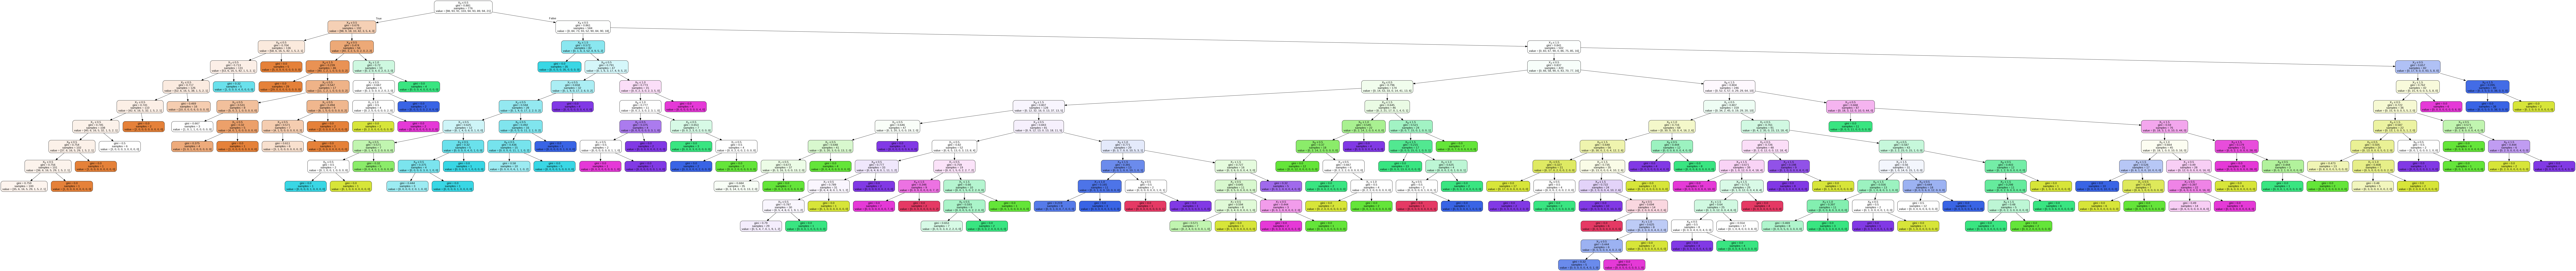

In [0]:
#def DT(datafile):
input_data=pd.read_csv('A2_OXOGame.csv')
x=input_data.iloc[:,1:-2] # Define the independent values as the positions on the board
y=input_data.iloc[:,-1] # Define the dependent values as the next best move

""" Train the decision tree. 
"""
clf=tree.DecisionTreeClassifier()
clf=clf.fit(x,y)

""" Plot the decision tree. 
"""
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) # Exporting as png image for clearer viewing
#    return clf

#print(DT('A1_OXOGame.csv').predict([[0,0,0,0,0,0,0,0,0]]))

**TASK 4**

Modify the following part of the MCTS function in the code provided so that, instead of doing a purely random search, it uses the learned classifier and finds out which action to take. Do the best action 90% of the time, while playing randomly 10%.

In [0]:
def UCT(rootstate, itermax, verbose = False):
    """ Conduct a UCT search for itermax iterations starting from rootstate.
        Return the best move from the rootstate.
        Assumes 2 alternating players (player 1 starts), with game results in the range [0.0, 1.0]."""
    
    rootnode = Node(state = rootstate)

    for i in range(itermax):
        node = rootnode
        state = rootstate.Clone()

        # Select
        while node.untriedMoves == [] and node.childNodes != []: # node is fully expanded and non-terminal
            node = node.UCTSelectChild()
            state.DoMove(node.move)

        # Expand
        if node.untriedMoves != []:  # if we can expand (i.e. state/node is non-terminal)
            m = random.choice(node.untriedMoves) 
            state.DoMove(m)
            node = node.AddChild(m, state)  # add child and descend tree

        # Rollout - this can often be made orders of magnitude quicker using a state.GetRandomMove() function
        randnum=randint(0,9)
        while state.GetMoves() != []: # while state is non-terminal
          if (randnum>8):
              state.DoMove(random.choice(state.GetMoves()))
          else:
              movex=clf.predict(np.reshape(state.board,(-1,9)))
              nextmove=int(movex[0])
              if state.board[nextmove] == 0:
                  state.DoMove(nextmove)
              else:
                  state.DoMove(random.choice(state.GetMoves()))
        # Backpropagate
        while node != None: # backpropagate from the expanded node and work back to the root node
            node.Update(state.GetResult(node.playerJustMoved)) # state is terminal. Update node with result from POV of node.playerJustMoved
            node = node.parentNode

    # Output some information about the tree - can be omitted
    #if verbose: print(rootnode.TreeToString(0)) #Uncomment to display tree info
    #else: print(rootnode.ChildrenToString()) #Uncomment to display tree info
    return sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move # return the move that was most visited

def UCTGame():
    """ Play a sample game between two UCT players where each player gets a different number 
        of UCT iterations (= simulations = tree nodes).
    """
    state = OXOState()
    data=[0,0,0,0,0,0,0,0,0,0,0] #Data for each play
    gameset=[0,0,0,0,0,0,0,0,0,0,0] #Data for entire game
    r=1 #Indicator of rows
    w=0 #Indicator of winner

    while state.GetMoves() != []:
        #print(str(state)) #Uncomment for displaying board
        if state.playerJustMoved == 1:
            m = UCT(rootstate=state, itermax=1000, verbose=False)  # play with values for itermax and verbose = True
        else:
            m = UCT(rootstate=state, itermax=100, verbose=False)
        state.DoMove(m)
        if state.GetResult(state.playerJustMoved) != False:
            #print(str(state)) #Uncomment for displaying modified board
            break

        """Create array of status of the board, next player, and next best move
        """
        gameset=np.concatenate((gameset,data),axis=0)
        data=state.board
        data=np.append(data,state.playerJustMoved)
        data=np.append(data,m)
        data=np.array(data)
        r+=1

    if state.GetResult(state.playerJustMoved) == 1.0:
        #print("Player " + str(state.playerJustMoved) + " wins!") #Uncomment to display winning player
        w=(state.playerJustMoved)+5
    elif state.GetResult(state.playerJustMoved) == 0.0:
        #print("Player " + str(3 - state.playerJustMoved) + " wins!") #Uncomment to display winning player
        w=(3-state.playerJustMoved)+5
    else: 
        #print("Nobody wins!") #Uncomment to display winning player
        w=5
    
    """Modify game set array 
    """
    gameset=np.reshape(gameset,(r,11)) #Define 11 columns (nine positions, next player, and next move)
    gameset_moves=gameset[:,0:9] #Separate moves from data
    gameset_actions=gameset[:,8:] #Separate actions from data
    gameset_actions=shift(gameset_actions,-1,cval=0) #Shift player and move columns up one row
    gameset=np.concatenate((gameset_moves,gameset_actions),axis=1) #Rejoin moves and actions
    gameset=np.delete(gameset,0,0) #Eliminate placeholder row
    gameset=np.delete(gameset,11,1) #Elimiante additional column
    gameset=pd.DataFrame(gameset) #Include headers to data frame; P for the position on the board
    gameset.iloc[r-2,9]=w #Include winning player
    gameset.iloc[r-2,10]=gameset.iloc[r-3,10] #Next best move is the same as previous
    return gameset

OXO=[[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0]] #Placeholder rows in order to concatenate
for i in range(100): #Uncomment if more than one game is to be run
  if __name__ == "__main__":
    """ Play a single game to the end using UCT for both players. 
    """
    gamedata=UCTGame()
    OXO=np.concatenate((OXO, gamedata),axis=0) #Concatenate every game's plays
OXO=np.delete(OXO,(0,1),0) #Delete placeholder rows
OXO=pd.DataFrame(OXO,columns=['P0','P1','P2','P3','P4','P5','P6','P7','P8','Player','Best move']) #Include headers to columns
print(OXO) #Optional for displaying game's plays
table=OXO.pivot_table(index=['Player'],aggfunc='size')
print(table) #Display won games per player (1 and 2 are normal moves; 5, 6 and 7 are won games by no one, player 1, and player 2 respectively)
#print("It was a tie ",table[5],"% of the time, player 1 won",table[7],"% of the time, and player 2 won ",table[9],"% of the time")
OXO.to_csv(r'A2Classifier_OXOGame.csv',index=True,header=True) #Convert data frame into a .csv file

     P0  P1  P2  P3  P4  P5  P6  P7  P8  Player  Best move
0     0   0   0   0   0   0   0   0   0       1          1
1     0   1   0   0   0   0   0   0   0       2          4
2     0   1   0   0   2   0   0   0   0       1          0
3     1   1   0   0   2   0   0   0   0       2          2
4     1   1   2   0   2   0   0   0   0       1          6
..   ..  ..  ..  ..  ..  ..  ..  ..  ..     ...        ...
771   2   0   0   1   1   0   0   0   0       2          5
772   2   0   0   1   1   2   0   0   0       1          2
773   2   0   1   1   1   2   0   0   0       2          6
774   2   0   1   1   1   2   2   0   0       1          1
775   2   1   1   1   1   2   2   0   0       5          1

[776 rows x 11 columns]
Player
1    384
2    292
5     86
6      6
7      8
dtype: int64


**TASK 5**

Collect the data using this approach. You now have a new set of states and actions — repeat the
above procedure for as many iterations as possible.

In [0]:
for i in range(10): #Number of iterations for training the DT, running and storing the data
    """ Train the decision tree. 
    """
    input_data=pd.read_csv('A2Classifier_OXOGame.csv')
    x=input_data.iloc[:,1:-2] # Define the independent values as the positions on the board
    y=input_data.iloc[:,-1] # Define the dependent values as the next best move

    clf=tree.DecisionTreeClassifier()
    clf=clf.fit(x,y)

    def UCT(rootstate, itermax, verbose = False):
        """ Conduct a UCT search for itermax iterations starting from rootstate.
            Return the best move from the rootstate. 
            Assumes 2 alternating players (player 1 starts), with game results in the range [0.0, 1.0]."""
    
        rootnode = Node(state = rootstate)

        for i in range(itermax):
            node = rootnode
            state = rootstate.Clone()

            # Select
            while node.untriedMoves == [] and node.childNodes != []: # node is fully expanded and non-terminal
                node = node.UCTSelectChild()
                state.DoMove(node.move)

            # Expand
            if node.untriedMoves != []:  # if we can expand (i.e. state/node is non-terminal)
                m = random.choice(node.untriedMoves) 
                state.DoMove(m)
                node = node.AddChild(m, state)  # add child and descend tree

            # Rollout - this can often be made orders of magnitude quicker using a state.GetRandomMove() function
            randnum=randint(0,9)
            while state.GetMoves() != []: # while state is non-terminal
              if (randnum>8):
                  state.DoMove(random.choice(state.GetMoves()))
              else:
                  movex=clf.predict(np.reshape(state.board,(-1,9)))
                  nextmove=int(movex[0])
                  if state.board[nextmove] == 0:
                      state.DoMove(nextmove)
                  else:
                      state.DoMove(random.choice(state.GetMoves()))
            # Backpropagate
            while node != None: # backpropagate from the expanded node and work back to the root node
                node.Update(state.GetResult(node.playerJustMoved)) # state is terminal. Update node with result from POV of node.playerJustMoved
                node = node.parentNode

        # Output some information about the tree - can be omitted
        #if verbose: print(rootnode.TreeToString(0)) #Uncomment to display tree info
        #else: print(rootnode.ChildrenToString()) #Uncomment to display tree info
        return sorted(rootnode.childNodes, key = lambda c: c.visits)[-1].move # return the move that was most visited

    """ Play the game to the end using UCT for both players. 
    """
    OXO=[[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0]] #Placeholder rows in order to concatenate
    for i in range(100): #Uncomment if more than one game is to be run
      if __name__ == "__main__":
        gamedata=UCTGame()
        OXO=np.concatenate((OXO, gamedata),axis=0) #Concatenate every game's plays
    
    """ Storing data of past games. 
    """
    OXO=np.delete(OXO,(0,1),0) #Delete placeholder rows
    OXO=pd.DataFrame(OXO,columns=['P0','P1','P2','P3','P4','P5','P6','P7','P8','Player','Best move']) #Include headers to columns
    print(OXO) #Optional for displaying game's plays
    print(OXO.pivot_table(index=['Player'],aggfunc='size')) #Display won games per player (1 and 2 are normal moves; 5, 6 and 7 are won games by no one, player 1, and player 2 respectively)
    OXO.to_csv(r'A2Classifier_OXOGame.csv',index=True,header=True) #Convert data frame into a .csv file

     P0  P1  P2  P3  P4  P5  P6  P7  P8  Player  Best move
0     0   0   0   0   0   0   0   0   0       1          0
1     1   0   0   0   0   0   0   0   0       2          4
2     1   0   0   0   2   0   0   0   0       1          2
3     1   0   1   0   2   0   0   0   0       2          1
4     1   2   1   0   2   0   0   0   0       1          3
..   ..  ..  ..  ..  ..  ..  ..  ..  ..     ...        ...
793   2   0   0   0   1   0   1   0   0       2          2
794   2   0   2   0   1   0   1   0   0       1          1
795   2   1   2   0   1   0   1   0   0       2          7
796   2   1   2   0   1   0   1   2   0       1          5
797   2   1   2   0   1   1   1   2   0       5          5

[798 rows x 11 columns]
Player
1    398
2    300
5     98
7      2
dtype: int64
     P0  P1  P2  P3  P4  P5  P6  P7  P8  Player  Best move
0     0   0   0   0   0   0   0   0   0       1          4
1     0   0   0   0   1   0   0   0   0       2          0
2     2   0   0   0   1   0   0   

**TASK 6**

Every 10 iterations of the whole algorithm, have an agent play with all its past self 10 games and record the results — are the agents improving?

In [0]:
moves=[]
for i in range(10): #Number of iterations for training the DT, running and storing the data
    
    """ Train the decision tree. 
    """
    input_data=pd.read_csv('A2Classifier_OXOGame.csv')
    x=input_data.iloc[:,1:-2] # Define the independent values as the positions on the board
    y=input_data.iloc[:,-1] # Define the dependent values as the next best move

    clf=tree.DecisionTreeClassifier()
    clf=clf.fit(x,y)

    """ Play the game to the end using UCT for both players. 
    """
    OXO=[[0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0]] #Placeholder rows in order to concatenate
    for i in range(100): #Uncomment if more than one game is to be run
      if __name__ == "__main__":
        gamedata=UCTGame()
        OXO=np.concatenate((OXO, gamedata),axis=0) #Concatenate every game's plays
    
    """ Storing data of past games. 
    """
    OXO=np.delete(OXO,(0,1),0) #Delete placeholder rows
    OXO=pd.DataFrame(OXO,columns=['P0','P1','P2','P3','P4','P5','P6','P7','P8','Player','Best move']) #Include headers to columns
    print(OXO) #Optional for displaying game's plays
    print(OXO.pivot_table(index=['Player'],aggfunc='size')) #Display won games per player (1 and 2 are normal moves; 5, 6 and 7 are won games by no one, player 1, and player 2 respectively)
    OXO.to_csv(r'A2Classifier_OXOGame.csv',index=True,header=True) #Convert data frame into a .csv file

KeyboardInterrupt: ignored

**References**

https://stackoverflow.com/questions/30399534/shift-elements-in-a-numpy-array

https://stackoverflow.com/questions/54731910/how-add-label-in-column-for-numpy-array

https://stackoverflow.com/questions/11106536/adding-row-column-headers-to-numpy-arrays


https://datatofish.com/export-dataframe-to-csv/

https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176

https://docs.scipy.org/doc/numpy/reference/generated/numpy.asmatrix.html

https://stackoverflow.com/questions/41950021/typeerror-not-supported-between-instances-of-str-and-int

https://datatofish.com/count-duplicates-pandas/